In [2]:
# %% [code] {"execution":{"iopub.execute_input":"2025-02-01T00:00:00Z","iopub.execute_output":"2025-02-01T00:00:01Z"}}
# Import necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, classification_report, roc_curve, auc)

# For sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
# %% [code]
# Optional: Use Dask if you work with huge datasets (uncomment if needed)
try:
    import dask.dataframe as dd
    print("Dask is available. For large datasets, you can use dask.dataframe to load the data.")
    # data = dd.read_csv('bot_detection_dataset.csv')  # Uncomment if needed.
except ImportError:
    print("Dask not installed; proceeding with Pandas.")

# Load dataset using Pandas
data = pd.read_csv('bot_detection_dataset.csv')
print("Dataset shape:", data.shape)
data.head()


Dask is available. For large datasets, you can use dask.dataframe to load the data.
Dataset shape: (50000, 11)


,User ID,Username,Tweet,Retweet Count,Mention Count,Follower Count,Verified,Bot Label,Location,Created At,Hashtags
0,132131,flong,Station activity person against natural majori...,85,1,2353,False,1,Adkinston,2020-05-11 15:29:50,NaN
1,289683,hinesstephanie,Authority research natural life material staff...,55,5,9617,True,0,Sanderston,2022-11-26 05:18:10,both live
2,779715,roberttran,Manage whose quickly especially foot none to g...,6,2,4363,True,0,Harrisonfurt,2022-08-08 03:16:54,phone ahead
3,696168,pmason,Just cover eight opportunity strong policy which.,54,5,2242,True,1,Martinezberg,2021-08-14 22:27:05,ever quickly new I
4,704441,noah87,Animal sign six data good or.,26,3,8438,False,1,Camachoville,2020-04-13 21:24:21,foreign mention


In [4]:
# %% [code]
# Convert 'Verified' to numeric (0/1)
data['Verified'] = data['Verified'].astype(int)

# Create a Tweet_Length feature (word count)
data['Tweet_Length'] = data['Tweet'].apply(lambda x: len(str(x).split()))

# Function to count hashtags in the Hashtags column
def count_hashtags(hashtag_str):
    if pd.isnull(hashtag_str):
        return 0
    # Split on comma or space; filter out empty strings
    hashtags = re.split('[, ]+', hashtag_str.strip())
    hashtags = [tag for tag in hashtags if tag != '']
    return len(hashtags)

data['Hashtag_Count'] = data['Hashtags'].apply(count_hashtags)

# Function to clean tweet text
def clean_text(text):
    text = str(text).lower()                      # Lowercase
    text = re.sub(r'http\S+', '', text)            # Remove URLs
    text = re.sub(r'@\w+', '', text)               # Remove mentions
    text = re.sub(r'#\w+', '', text)               # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)            # Remove punctuation
    text = re.sub(r'\d+', '', text)                # Remove digits
    return text.strip()

data['Clean_Tweet'] = data['Tweet'].apply(clean_text)

# Sentiment analysis using VADER
sid = SentimentIntensityAnalyzer()
data['Sentiment'] = data['Clean_Tweet'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Quick check of new features
data[['Tweet', 'Clean_Tweet', 'Tweet_Length', 'Hashtag_Count', 'Sentiment']].head()


,Tweet,Clean_Tweet,Tweet_Length,Hashtag_Count,Sentiment
0,Station activity person against natural majori...,station activity person against natural majori...,12,0,0.3612
1,Authority research natural life material staff...,authority research natural life material staff...,10,2,0.6597
2,Manage whose quickly especially foot none to g...,manage whose quickly especially foot none to g...,10,2,0.0000
3,Just cover eight opportunity strong policy which.,just cover eight opportunity strong policy which,7,4,0.7269
4,Animal sign six data good or.,animal sign six data good or,6,2,0.4404


In [5]:
# %% [code]
# Define feature names
text_feature = 'Clean_Tweet'
numeric_features = ['Retweet Count', 'Mention Count', 'Follower Count',
                    'Tweet_Length', 'Hashtag_Count', 'Verified', 'Sentiment']
target = 'Bot Label'

# Create a feature DataFrame and target vector
X = data[[text_feature] + numeric_features]
y = data[target]

# Split into training and testing sets (80/20 split, stratified by target)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
print("Train set:", X_train.shape, "Test set:", X_test.shape)


Train set: (40000, 8) Test set: (10000, 8)


In [9]:
# %% [code]
# Pipeline for text features
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2)))
])

# Pipeline for numeric features
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combine both pipelines
preprocessor = ColumnTransformer(transformers=[
    ('text', text_pipeline, text_feature),
    ('num', numeric_pipeline, numeric_features)
])

# Build full classification pipeline
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Train the classifier
clf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(max_features=5000,
                                                                                   ngram_range=(1,
                                                                                                2)))]),
                                                  'Clean_Tweet'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Retweet Count',
                                                   'Mention Count',
                                                   'Follower Count',
                                                   'Tweet_Length',
                                                   'Hashtag_Count', 'Verified',
                                                   'Sentiment'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

=== Logistic Regression Classifier Performance ===
Accuracy:  0.5000
Precision: 0.5004
Recall:    0.4938
F1 Score:  0.4971
AUC-ROC:   0.4998

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50      4996
           1       0.50      0.49      0.50      5004

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



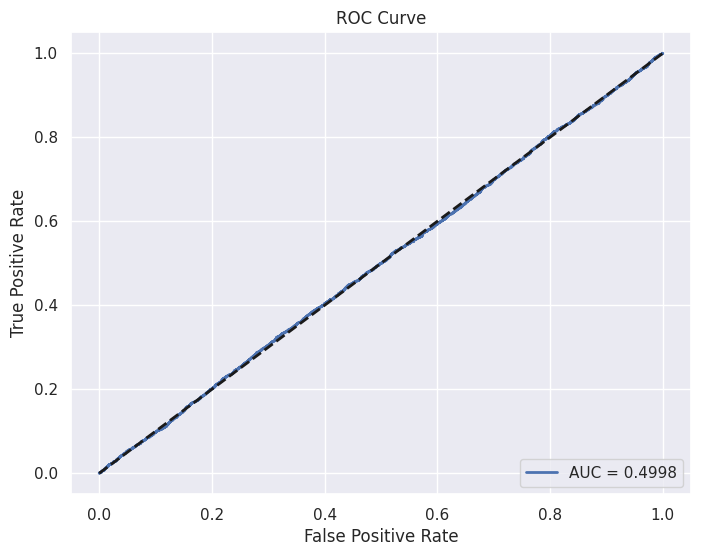

In [10]:
# %% [code]
# Make predictions on the test set
y_pred = clf_pipeline.predict(X_test)
y_proba = clf_pipeline.predict_proba(X_test)[:, 1]  # Confidence (probability of bot)

# Calculate performance metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print("=== Logistic Regression Classifier Performance ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC-ROC:   {roc_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc(fpr, tpr):.4f}', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [11]:
# %% [code]
# Build an Isolation Forest pipeline for numeric features only
iso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('isolation_forest', IsolationForest(contamination=0.1, random_state=42))
])

# Train on the numeric features of the training set
X_train_numeric = X_train[numeric_features]
iso_pipeline.fit(X_train_numeric)

# Predict anomaly scores on the test set
X_test_numeric = X_test[numeric_features]
iso_preds = iso_pipeline.predict(X_test_numeric)
# Convert IsolationForest output: -1 -> 1 (bot anomaly), 1 -> 0 (normal)
iso_preds_binary = np.where(iso_preds == -1, 1, 0)
print("Isolation Forest anomaly predictions (first 10):", iso_preds_binary[:10])


Isolation Forest anomaly predictions (first 10): [0 0 1 1 0 1 0 0 0 1]


In [12]:
# %% [code]
ensemble_preds = []
for lr_prob, iso_pred in zip(y_proba, iso_preds_binary):
    # Ensemble rule: flag as bot if either module indicates a bot
    if lr_prob > 0.5 or iso_pred == 1:
        ensemble_preds.append(1)
    else:
        ensemble_preds.append(0)
ensemble_preds = np.array(ensemble_preds)

# Evaluate ensemble predictions
acc_ens = accuracy_score(y_test, ensemble_preds)
prec_ens = precision_score(y_test, ensemble_preds)
rec_ens = recall_score(y_test, ensemble_preds)
f1_ens = f1_score(y_test, ensemble_preds)
roc_auc_ens = roc_auc_score(y_test, y_proba)  # Using LR probability as ensemble confidence

print("=== Ensemble Model Performance ===")
print(f"Accuracy:  {acc_ens:.4f}")
print(f"Precision: {prec_ens:.4f}")
print(f"Recall:    {rec_ens:.4f}")
print(f"F1 Score:  {f1_ens:.4f}")
print(f"AUC-ROC:   {roc_auc_ens:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, ensemble_preds))


=== Ensemble Model Performance ===
Accuracy:  0.5002
Precision: 0.5005
Recall:    0.5464
F1 Score:  0.5225
AUC-ROC:   0.4998

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.45      0.48      4996
           1       0.50      0.55      0.52      5004

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.50     10000
weighted avg       0.50      0.50      0.50     10000



Detection Report (first 5 rows):


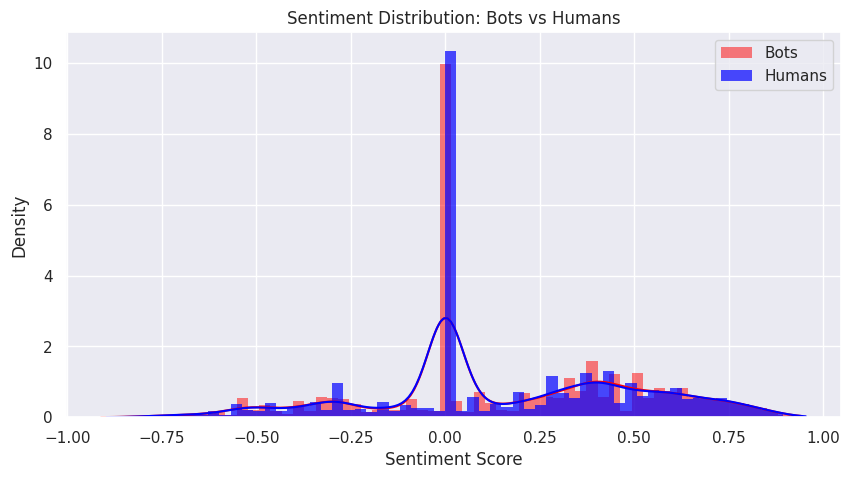

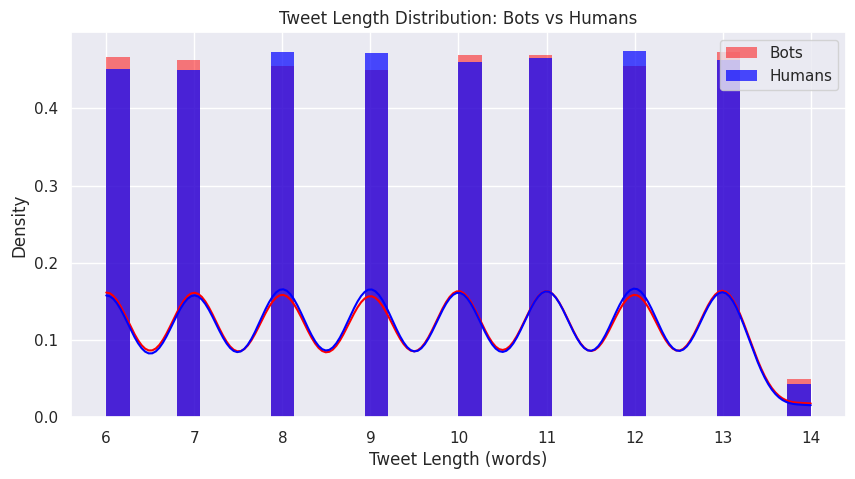

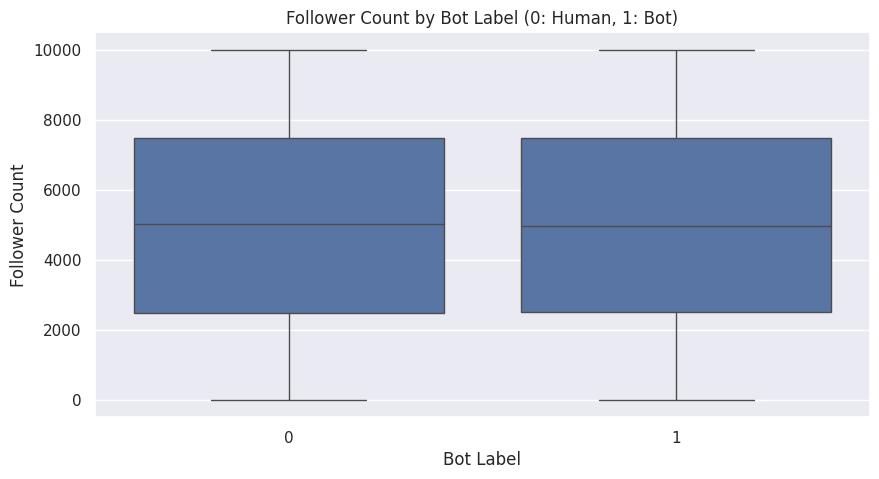

In [13]:
# %% [code]
# Create a detection report DataFrame for the test set
report_df = X_test.copy().reset_index(drop=True)
report_df['Actual_Bot_Label'] = y_test.values
report_df['LR_Probability'] = y_proba
report_df['Isolation_Forest_Pred'] = iso_preds_binary
report_df['Ensemble_Prediction'] = ensemble_preds
print("Detection Report (first 5 rows):")
report_df.head()

# ---- Insights and Visualizations ----

# 1. Sentiment Distribution for Bots vs Humans
plt.figure(figsize=(10, 5))
sns.histplot(data[data['Bot Label'] == 1], x='Sentiment', color='red', label='Bots', kde=True, stat="density", linewidth=0)
sns.histplot(data[data['Bot Label'] == 0], x='Sentiment', color='blue', label='Humans', kde=True, stat="density", linewidth=0, alpha=0.7)
plt.title("Sentiment Distribution: Bots vs Humans")
plt.xlabel("Sentiment Score")
plt.legend()
plt.show()

# 2. Tweet Length Distribution for Bots vs Humans
plt.figure(figsize=(10, 5))
sns.histplot(data[data['Bot Label'] == 1], x='Tweet_Length', color='red', label='Bots', kde=True, stat="density", linewidth=0)
sns.histplot(data[data['Bot Label'] == 0], x='Tweet_Length', color='blue', label='Humans', kde=True, stat="density", linewidth=0, alpha=0.7)
plt.title("Tweet Length Distribution: Bots vs Humans")
plt.xlabel("Tweet Length (words)")
plt.legend()
plt.show()

# 3. Follower Count Comparison via Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x='Bot Label', y='Follower Count', data=data)
plt.title("Follower Count by Bot Label (0: Human, 1: Bot)")
plt.xlabel("Bot Label")
plt.ylabel("Follower Count")
plt.show()


In [18]:
# %% [code]
def predict_bot(account_data):
    """
    Predict whether an account is a bot.

    The input dictionary should preferably contain the raw tweet text under 'Tweet'
    and the raw hashtags under 'Hashtags'. However, if these keys are missing but
    preprocessed keys (like 'Clean_Tweet') are present, the function will use them.

    Parameters:
        account_data (dict): Expected keys include:
            - 'Tweet' (raw tweet text) OR 'Clean_Tweet'
            - 'Retweet Count'
            - 'Mention Count'
            - 'Follower Count'
            - 'Verified'
            - 'Hashtags' (raw hashtags) OR the key 'Hashtag_Count'

    Returns:
        dict: {
            'Predicted_Bot_Label': int (0 or 1),
            'LR_Probability': float,
            'Isolation_Forest_Pred': int (0 or 1)
        }
    """
    # Create a one-row DataFrame from the input dictionary
    df = pd.DataFrame([account_data])

    # Check if 'Tweet' is provided; if not, try to use 'Clean_Tweet'
    if 'Tweet' not in df.columns:
        if 'Clean_Tweet' in df.columns:
            df['Tweet'] = df['Clean_Tweet']
        else:
            raise KeyError("Input dictionary must include 'Tweet' or 'Clean_Tweet'.")

    # Similarly, check for 'Hashtags'; if not provided, assign an empty string
    if 'Hashtags' not in df.columns:
        if 'Hashtag_Count' in df.columns:
            # If you have the count but not the raw hashtags, you can assign an empty string.
            df['Hashtags'] = ""
        else:
            raise KeyError("Input dictionary must include 'Hashtags' or 'Hashtag_Count'.")

    # If preprocessed features are not available, compute them.
    if 'Clean_Tweet' not in df.columns:
        df['Clean_Tweet'] = df['Tweet'].apply(clean_text)
    if 'Tweet_Length' not in df.columns:
        df['Tweet_Length'] = df['Tweet'].apply(lambda x: len(str(x).split()))
    if 'Hashtag_Count' not in df.columns:
        df['Hashtag_Count'] = df['Hashtags'].apply(count_hashtags)
    if 'Sentiment' not in df.columns:
        df['Sentiment'] = df['Clean_Tweet'].apply(lambda x: sid.polarity_scores(x)['compound'])

    # Ensure the features are in the same order as during training
    features = df[[text_feature] + numeric_features]

    # Get Logistic Regression confidence (bot probability)
    lr_probability = clf_pipeline.predict_proba(features)[:, 1][0]

    # Get Isolation Forest prediction for numeric features
    iso_prediction = iso_pipeline.predict(features[numeric_features])[0]
    iso_prediction_binary = 1 if iso_prediction == -1 else 0

    # Ensemble rule: flag as bot if either indicator is positive
    predicted_label = 1 if (lr_probability > 0.5 or iso_prediction_binary == 1) else 0

    return {
        'Predicted_Bot_Label': predicted_label,
        'LR_Probability': lr_probability,
        'Isolation_Forest_Pred': iso_prediction_binary
    }


# Test the prediction function with a sample from the test set
sample_input = X_test.iloc[0].to_dict()
print("Sample input:")
print(sample_input)

prediction_result = predict_bot(sample_input)
print("\nPrediction result for the sample:")
print(prediction_result)


Sample input:
{'Clean_Tweet': 'look our agent always police per', 'Retweet Count': 24, 'Mention Count': 1, 'Follower Count': 5429, 'Tweet_Length': 6, 'Hashtag_Count': 1, 'Verified': 1, 'Sentiment': 0.0}

Prediction result for the sample:
{'Predicted_Bot_Label': 1, 'LR_Probability': 0.5061629546658825, 'Isolation_Forest_Pred': 0}


In [19]:
# %% [code]
import joblib
from google.colab import files

# Package both models into a single dictionary
ensemble_model = {
    'clf_pipeline': clf_pipeline,
    'iso_pipeline': iso_pipeline,
    # Optionally, you can include any additional info (e.g., feature names, thresholds)
    'text_feature': text_feature,
    'numeric_features': numeric_features,
    'threshold': 0.5  # used for the LR probability decision
}

# Save the ensemble model to a file
model_filename = 'bot_detection_model.pkl'
joblib.dump(ensemble_model, model_filename)
print(f"Model saved as {model_filename}")

# Create a download link (this will prompt the file download in Google Colab)
files.download(model_filename)


Model saved as bot_detection_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import joblib

# Load the saved model
ensemble_model = joblib.load('bot_detection_model.pkl')
clf_pipeline = ensemble_model['clf_pipeline']
iso_pipeline = ensemble_model['iso_pipeline']
text_feature = ensemble_model['text_feature']
numeric_features = ensemble_model['numeric_features']
threshold = ensemble_model['threshold']

def predict_bot(account_data):
    """
    Given a dictionary of account/post data, predict whether it is a bot.
    This function uses the loaded clf_pipeline and iso_pipeline.
    """
    import pandas as pd

    # Create a one-row DataFrame from the input dictionary
    df = pd.DataFrame([account_data])

    # Ensure the raw 'Tweet' or 'Hashtags' are available or
    # assume preprocessed features exist.
    if 'Tweet' not in df.columns:
        if 'Clean_Tweet' in df.columns:
            df['Tweet'] = df['Clean_Tweet']
        else:
            raise KeyError("Input must include 'Tweet' or 'Clean_Tweet'.")

    if 'Hashtags' not in df.columns:
        df['Hashtags'] = ""

    # Compute missing features if needed (assuming you have the clean_text and count_hashtags functions)
    if 'Clean_Tweet' not in df.columns:
        df['Clean_Tweet'] = df['Tweet'].apply(clean_text)
    if 'Tweet_Length' not in df.columns:
        df['Tweet_Length'] = df['Tweet'].apply(lambda x: len(str(x).split()))
    if 'Hashtag_Count' not in df.columns:
        df['Hashtag_Count'] = df['Hashtags'].apply(count_hashtags)
    if 'Sentiment' not in df.columns:
        df['Sentiment'] = df['Clean_Tweet'].apply(lambda x: sid.polarity_scores(x)['compound'])

    # Make sure the features are in the same order as during training
    features = df[[text_feature] + numeric_features]

    # Get the Logistic Regression model's probability
    lr_probability = clf_pipeline.predict_proba(features)[:, 1][0]

    # Get the Isolation Forest's prediction for numeric features
    iso_prediction = iso_pipeline.predict(features[numeric_features])[0]
    iso_prediction_binary = 1 if iso_prediction == -1 else 0

    # Ensemble rule: classify as bot if either model indicates a bot
    predicted_label = 1 if (lr_probability > threshold or iso_prediction_binary == 1) else 0

    return {
        'Predicted_Bot_Label': predicted_label,
        'LR_Probability': lr_probability,
        'Isolation_Forest_Pred': iso_prediction_binary
    }

# Example usage in the backend
sample_input = {
    'Tweet': 'Look at our agent always on duty!',
    'Retweet Count': 24,
    'Mention Count': 1,
    'Follower Count': 5429,
    'Verified': 1,
    'Hashtags': '#agent, #duty'
}
result = predict_bot(sample_input)
print(result)


{'Predicted_Bot_Label': 1, 'LR_Probability': 0.5600220681570027, 'Isolation_Forest_Pred': 0}
